# 数据库分库分表

## 什么是分库分表
顾名思义，分库分表就是按照一定的规则，对原有的数据库和表进行拆分，把原本存储于一个库的数据分块存储到多个库上，把原本存储于一个表的数据分块存储到多个表上。

## 分库分表的方式

### 垂直分库/分表

垂直划分数据库是根据业务进行划分，例如将shop库中涉及商品、订单、用户的表分别划分出成一个库，通过降低单库（表）的大小来提高性能，但这种方式并没有解决高数据量带来的性能损耗。同样的，分表的情况就是将一个大表根据业务功能拆分成一个个子表，例如用户表可根据业务分成基本信息表和详细信息表等。

* 优点：
  1. 拆分后业务清晰，达到专库专用。
  2. 可以实现热数据和冷数据的分离，将不经常变化的数据和变动较大的数据分散再不同的库/表中。
  3. 便于维护


* 缺点：
  1. 不解决数据量大带来的性能损耗，读写压力依旧很大
  2. 不同的业务无法跨库关联（join），只能通过业务来关联

### 水平分库/分表

水平划分是根据一定规则，例如时间或id序列值等进行数据的拆分。比如根据年份来拆分不同的数据库。每个数据库结构一致，但是数据得以拆分，从而提升性能。又比如根据用户id的值，根据规则分成若干个表。每个表结构一致,（这点与垂直分库分表相反）。

* 优点：
  1. 单库（表）的数据量得以减少，提高性能
  2. 提高了系统的稳定性和负载能力
  3. 切分出的表结构相同，程序改动较少


* 缺点：
  1. 拆分规则较难抽象
  2. 数据分片在扩容时需要迁移
  3. 维护量增大
  4. 依然存在跨库无法join等问题，同时涉及分布式事务，数据一致性等问题。
  
## 分库分表中Bug解决方案

简而言之，分库分表中若出现事务，`join`，`group by`等操作时通常都是在应用的层面进行优化。

# HashMap

## HashMap简介

* `HashMap`是一个散列表，它存储的内容是键值对(`key-value`)映射。
* `HashMap`继承于`AbstractMap`，实现了`Map`、`Cloneable`、`java.io.Serializable`接口。
* `HashMap`的实现不是同步的，这意味着它不是线程安全的。它的`key`、`value`都可以为`null`。此外，`HashMap`中的映射不是有序的。

```java
public class HashMap<K,V>
    extends AbstractMap<K,V>
    implements Map<K,V>, Cloneable, Serializable { }
```

## HashMap结构

HashMap是通过"拉链法"实现的哈希表。它包括几个重要的成员变量：`table`, `size`, `threshold`, `loadFactor`, `modCount`:

* table是一个`Entry[]`数组类型，而`Entry`实际上就是一个单向链表。哈希表的"`key-value`键值对"都是存储在`Entry`数组中的。

* `size`是`HashMap`的大小，它是`HashMap`保存的键值对的数量。

* `threshold`是`HashMap`的阈值，用于判断是否需要调整`HashMap`的容量。`threshold`的值="容量\*加载因子"，当`HashMap`中存储数据的数量达到`threshold`时，就需要将HashMap的容量加倍。
　　
* `loadFactor`就是加载因子。
　　
* `modCount`是用来实现`fail-fast`机制的。

简单来说，HashMap由数组+链表组成的，数组是HashMap的主体，链表则是主要为了解决哈希冲突而存在的，如果定位到的数组位置不含链表（当前entry的next指向null）,那么对于查找，添加等操作很快，仅需一次寻址即可；如果定位到的数组包含链表，对于添加操作，其时间复杂度为O(n)，首先遍历链表，存在即覆盖，否则新增；对于查找操作来讲，仍需遍历链表，然后通过key对象的equals方法逐一比对查找。所以，性能考虑，HashMap中的链表出现越少，性能才会越好。

> 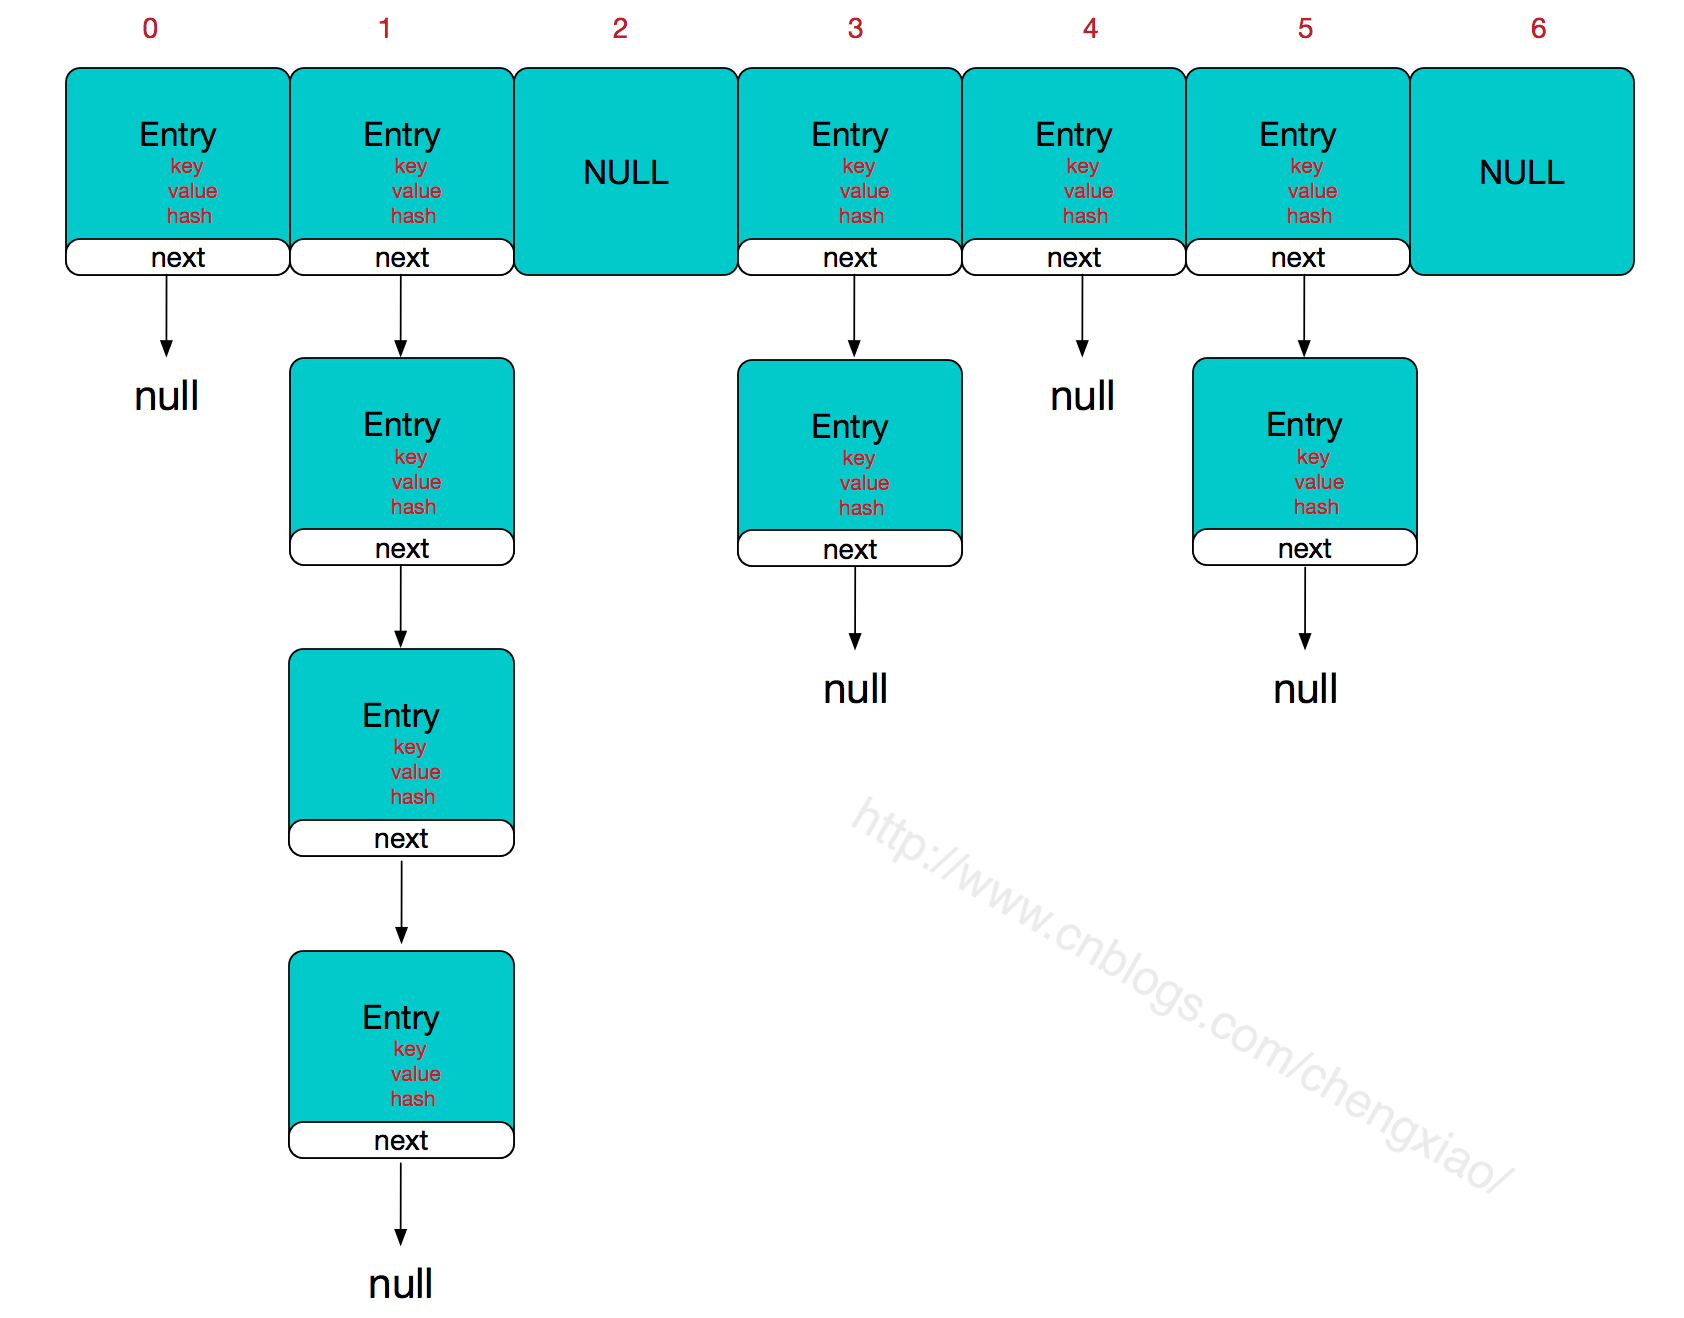

## concurrenthashmap

多线程环境下，使用Hashmap进行put操作会引起死循环，导致CPU利用率接近100%，所以在并发情况下不能使用HashMap。

`HashTable`容器使用`synchronized`来保证线程安全，但在线程竞争激烈的情况下`HashTable`的效率非常低下。因为当一个线程访问`HashTable`的同步方法时，其他线程访问`HashTable`的同步方法时，可能会进入阻塞或轮询状态。如线程1使用put进行添加元素，线程2不但不能使用put方法添加元素，并且也不能使用get方法来获取元素，所以竞争越激烈效率越低。

HashTable容器在竞争激烈的并发环境下表现出效率低下的原因，是因为所有访问HashTable的线程都必须竞争同一把锁，那假如容器里有多把锁，每一把锁用于锁容器其中一部分数据，那么当多线程访问容器里不同数据段的数据时，线程间就不会存在锁竞争，从而可以有效的提高并发访问效率，这就是ConcurrentHashMap所使用的锁分段技术，首先将数据分成一段一段的存储，然后给每一段数据配一把锁，当一个线程占用锁访问其中一个段数据的时候，其他段的数据也能被其他线程访问。

> 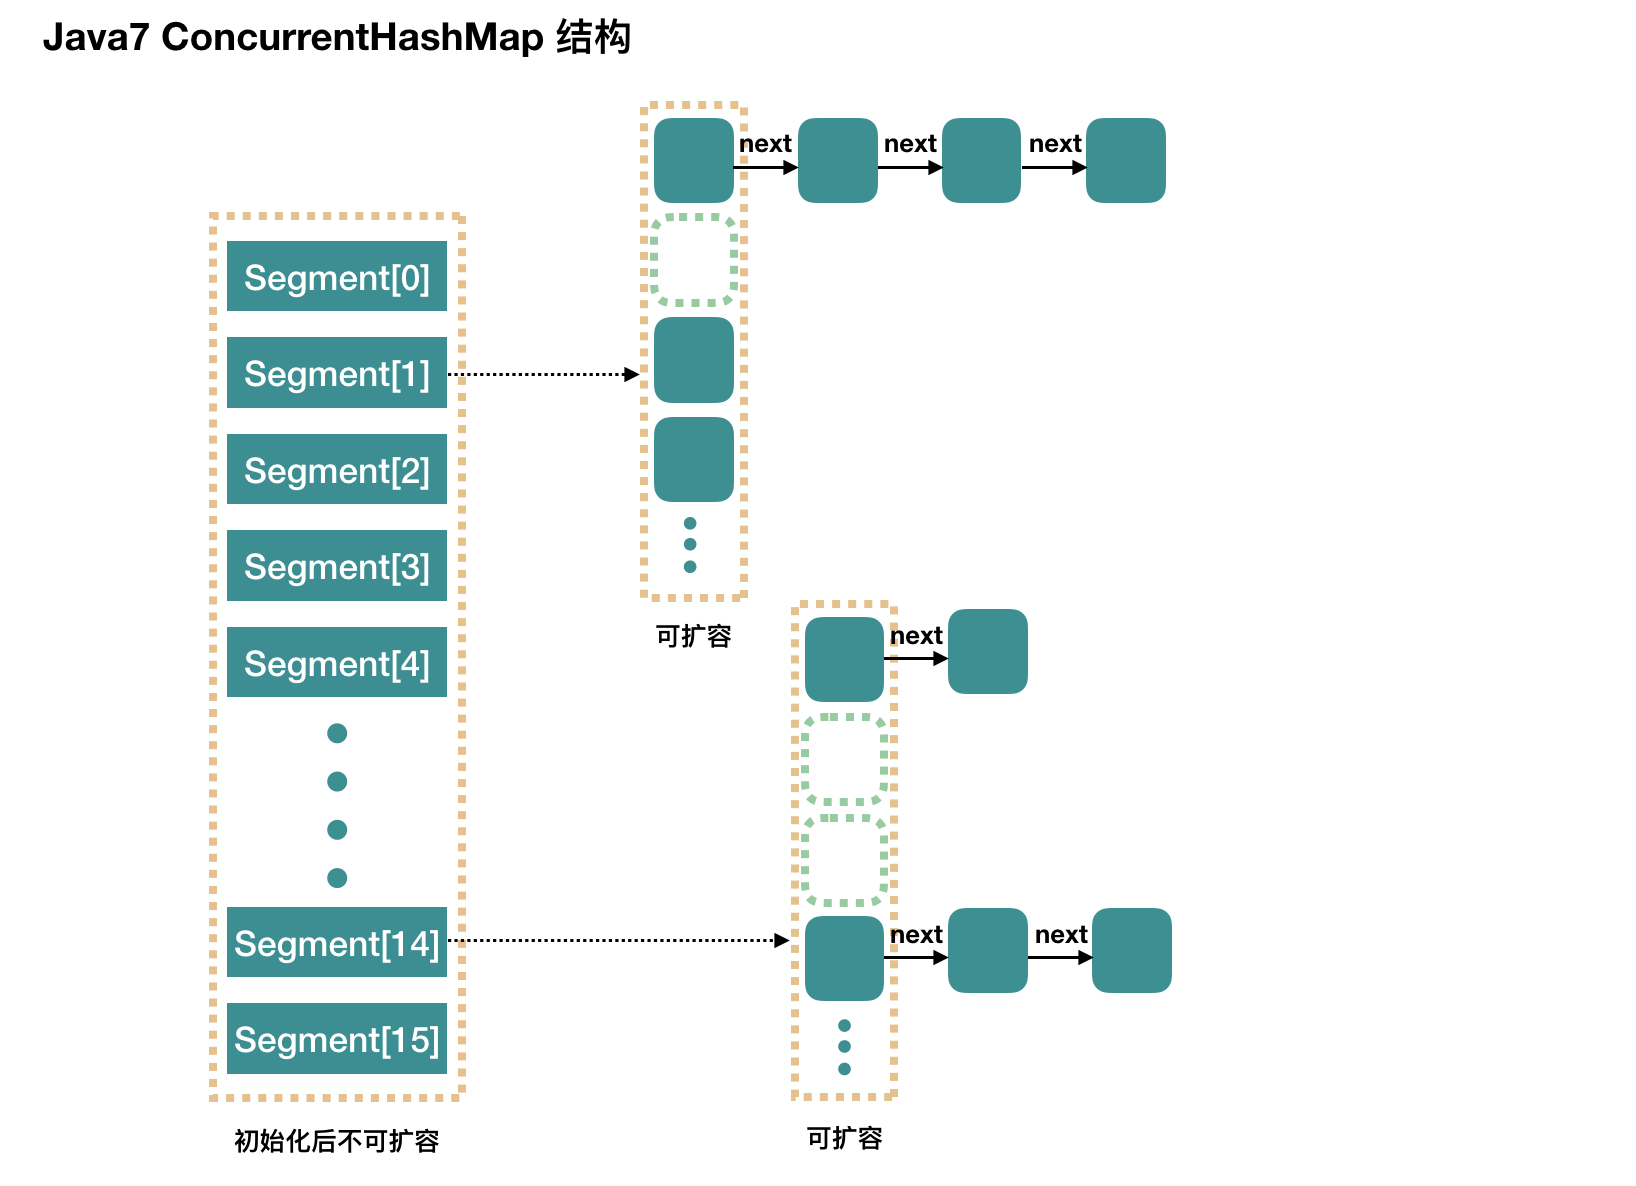

# HashTable

## Hashtable 简介

* 和HashMap一样，Hashtable 也是一个散列表，它存储的内容是键值对(key-value)映射。

* Hashtable 继承于Dictionary，实现了Map、Cloneable、java.io.Serializable接口。

* Hashtable 的函数都是同步的，这意味着它是线程安全的。它的key、value都不可以为null。此外，Hashtable中的映射不是有序的。

## HashMap和Hashtable的区别

HashMap和Hashtable都实现了Map接口，但决定用哪一个之前先要弄清楚它们之间的分别。主要的区别有：线程安全性，同步(synchronization)，以及速度。

1. HashMap几乎可以等价于Hashtable，除了HashMap是非synchronized的，并可以接受null(HashMap可以接受为null的键值(key)和值(value)，而Hashtable则不行)。

2. HashMap是非synchronized，而Hashtable是synchronized，这意味着Hashtable是线程安全的，多个线程可以共享一个Hashtable；而如果没有正确的同步的话，多个线程是不能共享HashMap的。Java 5提供了ConcurrentHashMap，它是HashTable的替代，比HashTable的扩展性更好。
    
3. 另一个区别是HashMap的迭代器(Iterator)是fail-fast迭代器，而Hashtable的enumerator迭代器不是fail-fast的。所以当有其它线程改变了HashMap的结构（增加或者移除元素），将会抛出ConcurrentModificationException，但迭代器本身的remove()方法移除元素则不会抛出ConcurrentModificationException异常。但这并不是一个一定发生的行为，要看JVM。这条同样也是Enumeration和Iterator的区别。
    
4. 由于Hashtable是线程安全的也是synchronized，所以在单线程环境下它比HashMap要慢。如果你不需要同步，只需要单一线程，那么使用HashMap性能要好过Hashtable。
    
5. HashMap不能保证随着时间的推移Map中的元素次序是不变的。

# ThreadLocal

该对象用于在不同线程中进行参数的复制。

首先，在每个线程Thread内部有一个`ThreadLocal.ThreadLocalMap`类型的成员变量`threadLocals`，这个`threadLocals`就是用来存储实际的变量副本的，键值为当前`ThreadLocal`变量，`value`为变量副本（即T类型的变量）。

初始时，在Thread里面，threadLocals为空，当通过ThreadLocal变量调用get()方法或者set()方法，就会对Thread类中的threadLocals进行初始化，并且以当前ThreadLocal变量为键值，以ThreadLocal要保存的副本变量为value，存到threadLocals。

然后在当前线程里面，如果要使用副本变量，就可以通过get方法在threadLocals里面查找。

# 数据库范式

目前关系数据库有六种范式：第一范式（1NF）、第二范式（2NF）、第三范式（3NF）、巴斯-科德范式（BCNF）、第四范式(4NF）和第五范式（5NF，又称完美范式）。

# 数据库隔离级别

* READ UNCIMMITTED（未提交读）

　　事务中的修改，即使没有提交，其他事务也可以看得到，比如说上面的两步这种现象就叫做脏读，这种隔离级别会引起很多问题，如无必要，不要随便使用

　　例子:还是售票系统，小明和小花是售票员，他们分别是两个不同窗口的员工，现在售票系统只剩下3张票，此时A来小华这里买3张票，B来小明买票，小华查到余票还有就给接了订单，就要执行第三步的时候，小明接到B的请求查询有没有余票。看到小华卖出了3张票，于是拒绝卖票。但是小华系统出了问题，第三步执行失败，数据库为保证原子性，数据进行了回滚，也就是说一张票都没卖出去。

　　总结:这就是事务还没提交，而别的事务可以看到他其中修改的数据的后果，也就是脏读。

* READ COMMITTED（提交读）

　　大多数数据库系统的默认隔离级别是READ COMMITTED，这种隔离级别就是一个事务的开始，只能看到已经完成的事务的结果，正在执行的，是无法被其他事务看到的。这种级别会出现读取旧数据的现象

　　例子:还是小明小华销售员，余票3张，A来小华那里请求3张订票单，小华接受订单，要卖出3张票，上面的销售步骤执行中的时候，B也来小明那里买票，由于小华的销售事务执行到一半，小明事务没有看到小华的事务执行，读到的票数是3，准备接受订单的时候，小华的销售事务完成了，此时小明的系统变成显示0张票，小明刚想按下鼠标点击接受订单的手又连忙缩了回去。

　　总结:这就是小华的事务执行到一半，而小明看不到他执行的操作，所以看到的是旧数据，也就是无效的数据

* REPEATABLE READ（可重复读）

 　　REPEATABLE READ解决了脏读的问题，该级别保证了每行的记录的结果是一致的，也就是上面说的读了旧数据的问题，但是却无法解决另一个问题，幻行，顾名思义就是突然蹦出来的行数据。指的就是某个事务在读取某个范围的数据，但是另一个事务又向这个范围的数据去插入数据，导致多次读取的时候，数据的行数不一致。

　　例子:销售部门有规定，如果销售记录低于规定的值，要扣工资，此时经理在后端控制台查看了一下小明的销售记录，发现销售记录达不到规定的次数，心里暗喜，准备打印好销售清单，理直气壮和小明提出，没想到打印出来的时候发现销售清单里面销售数量增多了几条，刚刚好达到要求，气的经理撕了清单纸。原来是小明在就要打印的瞬间卖出了几张票，因此避过了减工资的血光之灾。

　　总结:虽然读取同一条数据可以保证一致性，但是却不能保证没有插入新的数据

 
* SERIALIZABLE（可串行化）

　　SERIALIZABLE是最高的隔离级别，它通过强制事务串行执行（注意是串行），避免了前面的幻读情况，由于他大量加上锁，导致大量的请求超时，因此性能会比较底下，再特别需要数据一致性且并发量不需要那么大的时候才可能考虑这个隔离级别

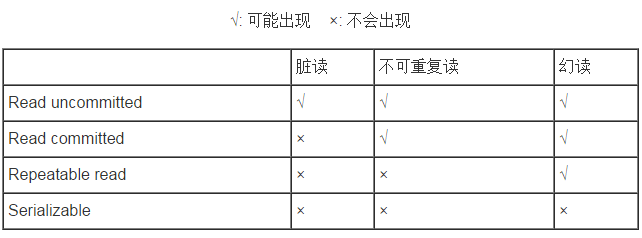

数据库中有三个严重的问题，分别是：

1. 赃读（读脏数据）：简单地说就是事务A读取了事务B未提交的数据，但是此时事务B发生了回滚，则事务A读取到的数据就是脏数据。

2. 不可重复读：这种故障意味着事务A读取了一条数据，但是在事务A执行接下来逻辑的过程中另一个事务将这个数据修改了，当事务A回来再读的时候发现数据被修改了，这就是不可重复读。

3. 幻读：这种故障的意思是事务A读取了一些数据，但是此时另一个事务又向数据库中插入了几条，此时事务A发现读取到的数据变多了，这就是幻读。

# 细碎的知识点

* ### `final`修饰的对象是不可变的吗？（注意区分`final`修饰的容器类对象，对象以及基本数据类型）
  * `final`指代不可变，如果使用来修饰基本数据类型，那么基本数据类型的内容则不能发生改变，如果用来修饰对象类型，除非被修饰的对象类型的成员变量也有`final`关键字修饰，否则被修饰的对象的成员变量状态是可以改变的，若用`final`修饰容器类，则容器类还是可以进行增减数据。一句话，`final`关键字只能将其直接限定的对象定义为不可变。

* ### <del>线程池方面的问题。</del>**（注：已经在并发一节中回答完毕）**

* ### c和c++中`new`操作和`malloc`操作之间的区别。
  1. 申请内存的区域不同：`malloc`申请的内存是在堆上，但是`new`却是在“自由存储区”，这是c++为`new`运算符定义的一个抽象概念。“自由存储区”可以是堆也可以是静态存储区，这取决于`new`运算符的具体实现。
  2. `new`运算符操作成功后返回的是申请内存的类型，但是`malloc`返回的却是`void*`，也就是说使用`malloc`运算符需要进行强制类型转换。
  3. `new`运算符分配内存失败时并不会返回`NULL`，而是直接抛出一个`bad_alloc`异常，但是`malloc`分配失败时会返回`NULL`。
  3. `new`运算符分配内存时不需要给出实际需要的内存大小，只需要给出需要对象的个数。但是使用`malloc`则需要具体算出需要的内存字节数。
  4. `new`运算符在申请对象内存时会调用构造函数和析构函数，但是`malloc`则不会。
  5. `malloc`不能针对对象进行内存申请，他只是给你一块内存，至于这块内存具体怎么用取决于使用者自己。

* ### python中`dict`实现的细节。
  * `dict`之所以能实现比较高的查询效率还是因为实现了哈希算法，这个只是知识点比较冷门，也没有必要过分深究。

* ### <del>java中原子变量的知识。</del>**（注：已经在并发一节中回答完毕）**

* ### java1.7之后的各种改变。
  * 字面量上的改变：1.7以后的虚拟机中的整型变量可以直接用二进制的方式赋值，同时可以在数字中间使用`_`来增加可读性，需要注意的是`_`只能加在数字中间。例如`int a = 0b01111_00000_11111_00000_10101_01010_10;`
  * `switch`增加了支持`String`类型。
  * `jdk1.7`之后在异常上面有了改进，实现了`try_with_resource`，让任何实现了`java.lang.AutoCloseable`和`java.io.Closeable`的对象都可以不用再像以前一样在`finally`字句中关闭资源。
  * 可以用一个`catch`块来捕获多个异常，而不用再像以前一样需要多个`catch`来捕获多个异常。同时可以在方法中抛出多个异常。
  * 增加了泛型自动推断。`List<String> list = new ArrayList<>();`

* ### java中`StringBuffer`和`StringBuilder`之间的区别。
  1. `StringBuilder`不是线程安全的。
  2. `StringBuffer`是线程安全的。
  
* ### 深拷贝和浅拷贝。
  * 深拷贝和浅拷贝与`Object`对象的`clone`方法有关，该方法提供对象的拷贝，但是该方法在`Object`对象中被标记为`protected`类型的，这就意味着对象实例无法进行直接调用，如果要进行对象复制就必须实现`Cloneable`接口，该接口中没有任何需要实现的方法，但是必须要实现该接口否则会有`java.lang.CloneNotSupportedException`异常。在类中需要重写`clone()`方法。这样，在类实例中调用`clone`方法就能实现对象的拷贝，但是，如果类中的成员不仅仅有基本数据类型，那么针对类中的对象类型也需要其实现`Cloneable`接口并重写`clone()`方法，然后在拥有这个对象类型的类的`clone`方法中调用这个类成员变量的`clone`方法以实现深拷贝，具体的使用如下所示：
```Java
//Man.java
public class Man implements Cloneable{
            private String name;
            private Address address;
            public Man(String name, String province, String city) {
                this.address = new Address(province, city);
                this.name = name;
            }
            public Object clone() throws CloneNotSupportedException {
                Man m = (Man) super.clone();
                m.address = (Address) address.Clone();
                return m;
            }
            public String getName() {
                return name;
            }
            public Address getAddress() {
                return address;
            }
}
//Address.java
public class Address implements Cloneable {
    
            private String province;
            private String city;
            public Address(String province, String city) {
                this.province = province;
                this.city = city;
            }
            public Object Clone() throws CloneNotSupportedException {
                return super.clone();
            }
            public String getProvince() {
                return province;
            }
            public void setProvince(String province) {
                this.province = province;
            }
            public String getCity() {
                return city;
            }
}
//test.java
 @Test
    public void test17() throws CloneNotSupportedException {
    	Man man = new Man("David", "Shannxi", "HanZhong");
    	Man man1 = (Man) man.clone();
    	man.getAddress().setProvince("HuBei");
    	Man man2 = man;
    	System.out.println(man);
    	System.out.println(man1);
    	System.out.println(man2);
    	System.out.println(man.getAddress());
    	System.out.println(man1.getAddress());
    	System.out.println(man2.getAddress());
    	System.out.println(man.getAddress().getProvince());
    	System.out.println(man1.getAddress().getProvince());
    	System.out.println(man2.getAddress().getProvince());
    }
```
输出：

```shell
        com.ilmare.Domain.Man@3439f68d
        com.ilmare.Domain.Man@dbd940d
        com.ilmare.Domain.Man@3439f68d
        com.ilmare.Domain.Address@71d15f18
        com.ilmare.Domain.Address@17695df3
        com.ilmare.Domain.Address@71d15f18
        HuBei
        Shannxi
        HuBei
```

* ### java中Object对象的`hashcode`和`equals`之间的联系。
  * `hashcode`和`equals`是`Object`对象中两个方法，前者是产生一个对象的哈希值，后者是用于判断两个对象的内容是否相等，这两个方法非常重要，如果一个对象想要用于`HashSet`，`HashMap`等与哈希有关的容器时特别是`HashSet`就必须重写这两个方法，因为与哈希有关的容器在计算对象的哈希值时用到的就是其`hashcode()`方法，例如`HashSet`为什么能够快速地放入对象且保证容器内对象不冲突就是依靠对象的哈希值计算存储地址来实现的，如果一个自定义对象不重写这两个方法而是用`Object`中的，那么就会出现很大问题。这两个方法在jdk规范中要求如下：
    1. 相等（相同）的对象必须具有相等的哈希码（或者散列码）。
    2. 如果两个对象的hashCode相同，它们并不一定相同。
    在`Object`类中`equals()`方法就是简单地对比两个对象的地址，而`hascode()`方法是一个本地方法，也就是说其实现与本地计算机有关。回到刚才的例子，如果一个自定义对象不重写这两个方法那么很有可能两个相同的对象却能计算出不同的哈希值，那么在使用`HashSet`时可能就会出现集合中拥有两个相同对象的情况。`equals`的本意是对比两个对象的内容是否相同，如果补充些这个方法那么`equals`就变成了对比两个对象的地址，显然是不符合设计的。一个比较典型的例子是这样：
```Java
//Student.java
class Student{
            int num;
            String name;
            public Student(String name, int num){
                this.num = num;
                this.name = name;
            }
            public int hashCode(){
                return num * name.hashCode();
            }
            public boolean equals(Object o){
                if (!(o instanceof Student)){
                    return false;
                }
                Student e = (Student) o;
                return num == s.num && names.equals(s.name)
            }
            public String toString(){
                return num + ":" + name;
            }
}
```
* ### servlet是线程安全的吗？
  1. `servlet`是一个单例对象，因此不是线程安全的。每次有网络请求时，tomcat都是为这些请求创建一个线程，然后线程根据请求来获取对应的servlet对象，每个servlet对象都是单例获取的，因此会存在servlet争用的现象。

 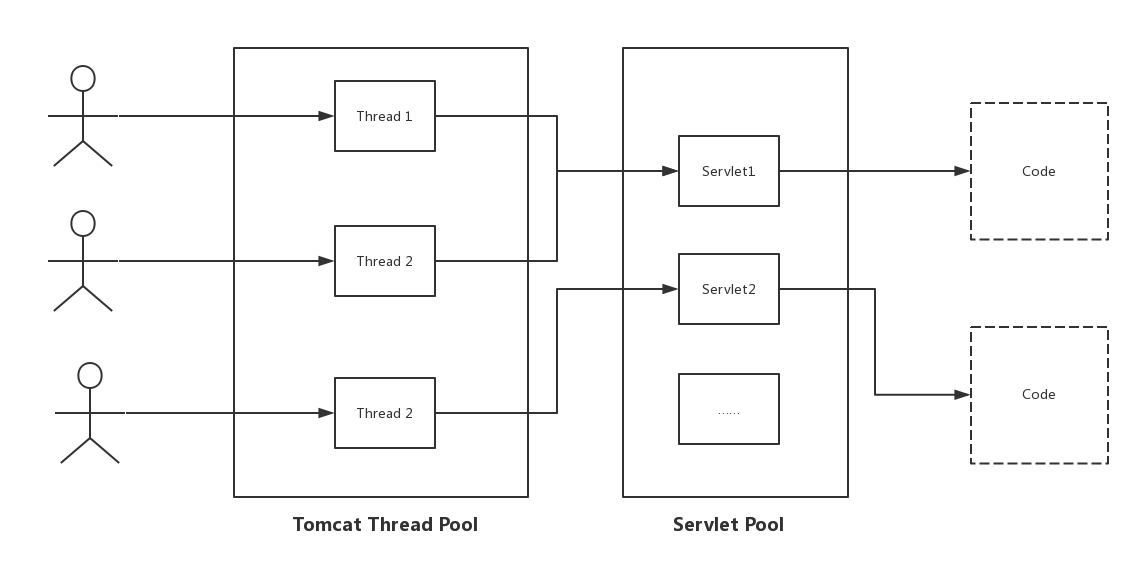

* ### 线程的状态。
  1. 新建(NEW)：新创建了一个线程对象。
  2. 可运行(RUNNABLE)：线程对象创建后，其他线程(比如main线程）调用了该对象的start()方法。该状态的线程位于可运行线程池中，等待被线程调度选中，获取cpu 的使用权 。
  3. 运行(RUNNING)：可运行状态(runnable)的线程获得了cpu 时间片（timeslice） ，执行程序代码。
  4. 阻塞(BLOCKED)：阻塞状态是指线程因为某种原因放弃了cpu 使用权，也即让出了cpu timeslice，暂时停止运行。直到线程进入可运行(runnable)状态，才有机会再次获得cpu timeslice 转到运行(running)状态。阻塞的情况分三种： 
    1. 等待阻塞：运行(running)的线程执行o.wait()方法，JVM会把该线程放入等待队列(waitting queue)中。
    2. 同步阻塞：运行(running)的线程在获取对象的同步锁时，若该同步锁被别的线程占用，则JVM会把该线程放入锁池(lock pool)中。
    3. 其他阻塞：运行(running)的线程执行Thread.sleep(long ms)或t.join()方法，或者发出了I/O请求时，JVM会把该线程置为阻塞状态。当sleep()状态超时、join()等待线程终止或者超时、或者I/O处理完毕时，线程重新转入可运行(runnable)状态。
  5. 死亡(DEAD)：线程run()、main() 方法执行结束，或者因异常退出了run()方法，则该线程结束生命周期。死亡的线程不可再次复生。
* ### 虚拟机查看内存状态
  * jmap(Memory Map for Java)命令用于生成堆转储快照（一般称之为heapdump或者dump文件）。如果不使用jump文件，要想获取Java堆转储快照，还有一些比较暴力的方法：譬如使用`-XX;+HeapDumpOnOutOfMemoryError`参数，可以让虚拟机在OOM之后自动生成dump文件，通过`-XX:+HeapDumpOnCtrlBreak`则可以使用`[Ctrl]+[Break]`键让虚拟机生成dump文件，又或者在Linux系统下通过`kill -3`命令发送进程退出信号“吓唬”一下虚拟机，也能拿到dump文件。`jmap`命作用不仅仅在于拿到dump文件，他还可以查询`finalize`执行队列，Java堆和永久代的详细信息，如空间使用率，当前使用的是哪种收集器等。其主要的参数如下：

|选项|作用|
|:-:|:-:|
|-dump|生成Java堆转储快照。格式为：-dump:[live,]format=b,file=\<filename\>,其中live子参数说明是否只dump出存活对象|
|-finalizerinfo|显示在F-Queue中等待Finalizer线程执行finalize方法的对象。只在Linux/Solaris平台下有效|
|-heap|显示Java堆详细信息，如使用哪种回收器、参数配置、分代情况等。只在Linux/Solaris平台下有效|
|-histo|显示堆中对象的统计信息，包括类，实例数量，合计容量|
|-permstat|以ClassLoader为统计口径显式永久代内存状态，只在Linux/Solaris平台下有效|
|-F|当虚拟机进程对-dump选项没有响应时，可以使用这个选项强制生成dump快照。只在Linux/Solaris系统下有效|

* ### 红黑树
  * 红黑树是一种二叉查找树，平常的二分查找树很有可能因为数据的问题导致查找树的一个子树过长从而造成查找性能下降，但是红黑树却是一个几乎“平衡”的二叉树，其**最长查找路径不超过最短查找路径的2倍**，红黑树的“红”和“黑”的概念是一个抽象的概念，作用是将不平衡的二叉树构建地平衡一些，红黑树的特点如下：
    1. 每个节点或者是黑色，或者是红色。
    2. 根节点是黑色。
    3. 每个叶子节点（NIL）是黑色。 \[注意：这里叶子节点，是指为空(NIL或NULL)的叶子节点！\]
    4. 如果一个节点是红色的，则它的子节点必须是黑色的。
    5. 从一个节点到该节点的子孙节点的所有路径上包含相同数目的黑节点。 
    
    为了保证红黑树“平衡的”特征（其查找复杂度约为$log(n)$），每次在对红黑树进行插入或删除时都要对树的结构进行调整，以保证其平衡性。在进行插入操作时，首先将节点插入到他应该在的地方，然后将该节点的“颜色”变为**红色**，之所以变为红色是因为这样能够最大限度地避免违背上面的红黑树规则，然后再依据一系列规则来调整红黑树，直到整个树不违背任意一条红黑树约束：
    
|情况|情况说明|处理办法|
|:-:|:-:|:-:|
|case1|当前节点的父节点是红色，且当前节点的祖父节点的另一个子节点（叔叔节点）也是红色。|1. 将“父节点”设为黑色。2. 将“叔叔节点”设为黑色.3. 将“祖父节点”设为“红色”。4. 将“祖父节点”设为“当前节点”(红色节点)；即，之后继续对“当前节点”进行操作。|
|case2|当前节点的父节点是红色，叔叔节点是黑色，且当前节点是其父节点的右孩子|1. 将“父节点”作为“新的当前节点”。2. 以“新的当前节点”为支点进行左旋。|
|case3|当前节点的父节点是红色，叔叔节点是黑色，且当前节点是其父节点的左孩子|1. 将“父节点”设为“黑色”。2. 将“祖父节点”设为“红色”.3. 以“祖父节点”为支点进行右旋。|
    
   红黑树的删除较为复杂，在这里就不再赘述，可以参考这篇文章：[红黑树的插入语删除](https://www.cnblogs.com/xuxinstyle/p/9556998.html)
    
* ### 设计模式
  * 创建性模式：
     1. 工厂模式：主要解决接口选择问题，创建过程延迟到子类进行。
     2. 抽象工厂模式：创建一个相关对象的工厂，每个工厂按照工厂模式提供的对象。
     3. 单例模式：避免一个全局使用的类频繁创建与销毁。
     4. 构建者模式：使用多个简单的对象一步步构建成一个复杂的对象。
     5. 原型模式：创建重复的对象。
   * 结构型模式：
     1. 适配器模式：适配器继承或依赖已有的对象，实现想要的接口。
     2. 装饰器模式：在不想增加很多子类的情况下扩展类，动态地给一个对象增加额外的职责。
     3. 代理模式：为其他对象提供一种代理以控制对这个对象的访问。
     4. 外观模式：像现有的系统添加一个接口，来隐藏系统的复杂性。
     5. 桥接模式：将抽象部分与实现部分分离，使他们都可以独立的变化。
     6. 组合模式：树枝和叶子实现统一的接口，树枝内部组合该接口。
     7. 享元模式：减少创建对象的数量，以减少内存占用和提高性能，例如：UITableViewCell。
   * 行为型模式：
     1. 策略模式：定义一系列算法，把他们一个个包装起来，并且使他们可以相互替换。
     2. 模板模式：有一些通用的方法，但是在没一个子类都重写此方法。
     3. 观察者模式：解决一个对象改变状态给其他对象通知的问题。
     4. 迭代器模式：提供一种方法顺序访问一个聚合对象中各个元素，而又无序暴露该对象的内部表示。
     5. 责任链模式：无需关心处理细节和请求传递，徐只要将请求发送到责任链上即可。
     6. 命令模式：将一个请求封装成一个对象。从而用不同的请求对客户进行参数化。
     7. 备忘录模式：保存一个对象的某个状态，一边在适当的时间恢复对象。
     8. 状态模式： 独享行为依赖于它的状态（属性），并且可以根据他的状态改变而改变它的相关行为。
     9. 访问者模式：在被访问的类里面加上一个对外提供访问者接口来进行判断。
     10. 中介者模式：多个类相互耦合，将各个类解耦。
     11. 解释器模式：实现一个表达式接口，解释一个特定的上下文。
* ### `python`中匿名函数的优点（也就是lambda表达式）
  * 非匿名函数在定义时就创建函数对象和作用域对象。以后及时未调用，也占空间
  * 匿名函数只有在调用时，才会创建函数对象和作用域对象。调用完后立即释放，节省内存。适合做回调函数

* ### `jre`与`jdk`的概念和联系

* ### 常见的运行时异常（运行时异常与普通异常的区别与联系）

* ### 面向对象中多态的理解

* ### <del>tcp三次握手与四次挥手以及tcp流量控制</del>**该问题已经在网络一节中回答完毕**

* ### io的多路复用，阻塞io与非阻塞io

* ### 事件驱动模式

* ### `HashMap`和`ArrayList`的容量扩增知识点

* ### `List`和链表的底层不同之处

* ### `ConcurrentHashMap`分段锁的知识点

* ### 虚函数表
   * 虚函数表是C++中实现多态的最重要手段，C++标准中虽然定义了虚函数的行为，但是却将实现方法留给了编译器作者，通常情况下编译器处理虚函数的做法是：给每一个对象增加一个隐藏的域，这个域和对象中用户定义的字段或方法平级，但是却被隐藏起来，该域是一个指针，指向一个地址表被称作是**虚函数表（virtual function table）**。该地址表中包含一系列函数地址，这些函数地址就是类中定义的函数的入口地址。当有父类和子类同时针对一个方法重写而该方法又被声明为`virtual`的时候，父类和子类对象的隐藏域指针指向的虚函数表中对应方法的地址是不相同的，依靠这种特性就能保证实现多态。
   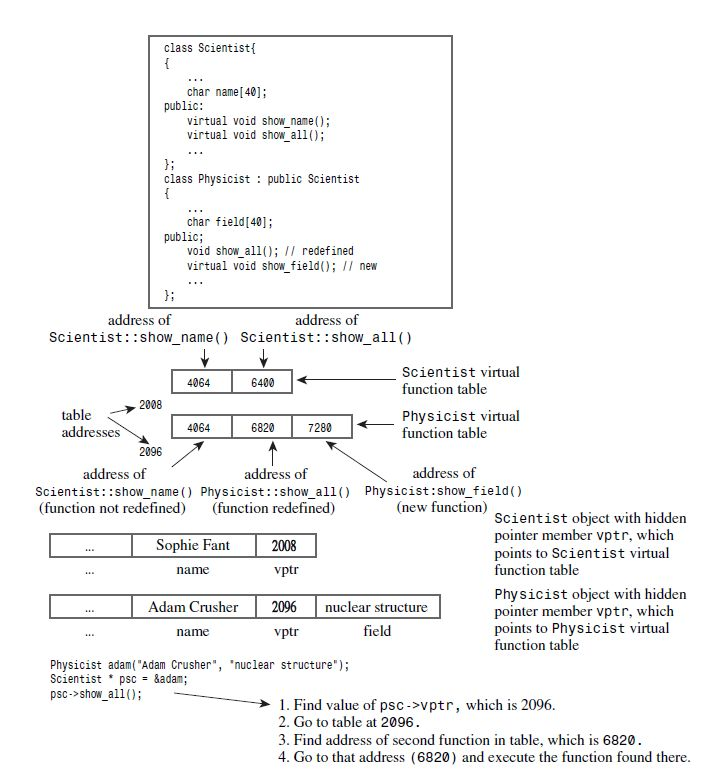

由上面的图可以看出，C++中类方法的索引几乎都是通过虚函数表来实现的，子类要调用父类的方法（即使子类没有重写这个方法）也是通过在虚函数表中天填入父类方法的函数地址实现的。

* ### 数据库三大范式

* ### `HashMap`的扩容为什么是2的倍数。

* ### ssl证书的各种知识点。